In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# dowload cats and dogs dataset
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
dataset_path = tf.keras.utils.get_file("cats_and_dogs_filtered.zip", origin=dataset_url, extract=True)
dataset_dir = dataset_path.replace("cats_and_dogs_filtered.zip", "cats_and_dogs_filtered")

train_dir = f"{dataset_dir}/train"
validation_dir = f"{dataset_dir}/validation"

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [3]:
# Make data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(160, 160), batch_size=32, class_mode="binary"
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=(160, 160), batch_size=32, class_mode="binary"
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
# Load MobileNetV2 without superior layers
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(160, 160, 3))

# Freeze base model layers
base_model.trainable = False

# Add personalized layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Substitui Flatten para lidar melhor com convoluções
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(1, activation="sigmoid")(x)  # Saída binária para cães e gatos

# Build the model
model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Train superior layers
model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 535ms/step - accuracy: 0.8327 - loss: 0.3331 - val_accuracy: 0.9610 - val_loss: 0.0946
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 241ms/step - accuracy: 0.9242 - loss: 0.1558 - val_accuracy: 0.9630 - val_loss: 0.0967
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.9488 - loss: 0.1281 - val_accuracy: 0.9600 - val_loss: 0.0981
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 261ms/step - accuracy: 0.9448 - loss: 0.1223 - val_accuracy: 0.9640 - val_loss: 0.0943
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 276ms/step - accuracy: 0.9542 - loss: 0.1154 - val_accuracy: 0.9630 - val_loss: 0.1001
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 244ms/step - accuracy: 0.9562 - loss: 0.1294 - val_accuracy: 0.9450 - val_loss: 0.1337
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step - accuracy: 0.9601 - loss: 0.1154 - val_accuracy: 0.9640 - val_loss: 0.0932
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - accuracy: 0.9586 - loss: 0.1046 - val_accuracy: 0.965

In [6]:
# Fine Tuning
# Unfreeze some layers from the base model
base_model.trainable = True

# Recompile the model with a smaller learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Retrain the entire model
model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
)


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 97s 653ms/step - accuracy: 0.8120 - loss: 0.5185 - val_accuracy: 0.9560 - val_loss: 0.1191
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - accuracy: 0.9070 - loss: 0.2245 - val_accuracy: 0.9580 - val_loss: 0.1114
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.9401 - loss: 0.1567 - val_accuracy: 0.9580 - val_loss: 0.1113
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.9397 - loss: 0.1503 - val_accuracy: 0.9670 - val_loss: 0.0915
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 267ms/step - accuracy: 0.9482 - loss: 0.1304 - val_accuracy: 0.9690 - val_loss: 0.0885


### Using MobileNetV2 model before transfer **learn**

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predições para as 5 classes mais prováveis:
1: wool (0.0573)
2: French_bulldog (0.0490)
3: hog (0.0472)
4: hammer (0.0386)
5: lab_coat (0.0311)


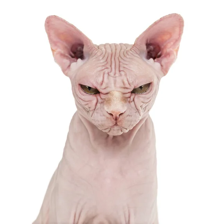

In [34]:
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions, preprocess_input
from PIL import Image
import numpy as np
import requests
import io

# load model
imagenet_model = MobileNetV2(weights="imagenet", include_top=True)

img_url = "https://st3.depositphotos.com/1594920/18263/i/450/depositphotos_182639510-stock-photo-sphynx-hairless-cat-4-years.jpg"

response = requests.get(img_url, stream=True)
img = Image.open(io.BytesIO(response.content))

img = img.resize((224, 224))
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

predictions = imagenet_model.predict(img_array)

decoded_predictions = decode_predictions(predictions, top=5)

print("Top 5 predicted classes with highest scores:")
for i, (imagenet_id, label, prob) in enumerate(decoded_predictions[0]):
    print(f"{i+1}: {label} ({prob:.4f})")

img


### Using the new model, after Transfer Learn

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Probability: 0.9956
Predicted class: cat


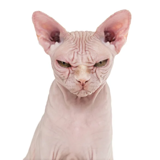

In [32]:
response = requests.get(img_url, stream=True)
img = Image.open(io.BytesIO(response.content))

# Resize the image using PIL
img = img.resize((160, 160))

# Convert the PIL Image to a NumPy array
img_array = np.array(img)

# Add an extra dimension for the batch
img_array = np.expand_dims(img_array, axis=0)

# Normalize the pixels
img_array = img_array / 255.0

# Make the prediction with the complete model
prediction = model.predict(img_array)
dog_prediction = prediction[0][0]

# Determine the class with the highest probability
predicted_class = "cat" if dog_prediction < 0.5 else "dog"

# Display the probabilities for both classes
print(f"Probability: {(dog_prediction if predicted_class == 'dog' else (1 - dog_prediction)):.4f}")
print(f"Predicted class: {predicted_class}")
img